In [ ]:
import os #
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

### Data download

In [ ]:
!curl -L "https://universe.roboflow.com/ds/AaI8EaNFXV?key=QV5qUOZUNF" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/ #menuju directory yang sudah ada
%mkdir images/ #make directory named images
%mv train images/train #move folder train images ke train
%mv test images/test
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   2717      0 --:--:-- --:--:-- --:--:--  2717
100 23.4M  100 23.4M    0     0  11.7M      0  0:00:02  0:00:02 --:--:-- 15.9M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
   creating: test/Non Stress/
 extracting: test/Non Stress/S010_006_00000015_png.rf.7c70c4ef1b1d9cd81f788c19695b5ad7.jpg  
 extracting: test/Non Stress/S026_001_00000013_png.rf.0d235f8dd3b7736d1e59a1414bc6b5b5.jpg  
 extracting: test/Non Stress/S026_001_00000014_png.rf.409a8e0707f60866eb0cadd2d2c0cd20.jpg  
 extracting: test/Non Stress/S026_002_00000015_png.rf.9a8d62c116f34b3450cce4bd97b81422.jpg  
 extracting: test/Non Stress/S035_006_00000016_png.rf.fda05b6e82f245de56e2b31aeb51b8e9.jpg  
 extracting: test/Non Stress/S037_006_00000020_png.rf.53de0f957d3b95ffc

We need to turn this dataset into a Tensorflow Dataset format. Fortunately, Tensorflow provides the ImageFolder dataset structure which is compatible with the format we downloaded the data in.

We will then use the builder to build the raw versions of our train, test, and validation data.

In [ ]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='images/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=98, num_shards=1>,
        'train': <SplitInfo num_examples=785, num_shards=1>,
        'valid': <SplitInfo num_examples=98, num_shards=1>,
    },
    citation="""""",
)


Show images and labels from the training set:

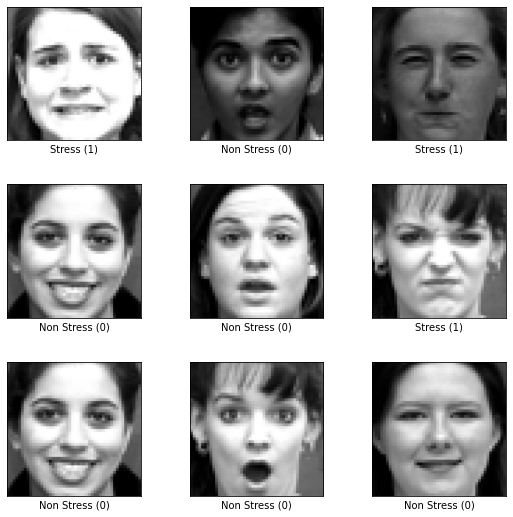

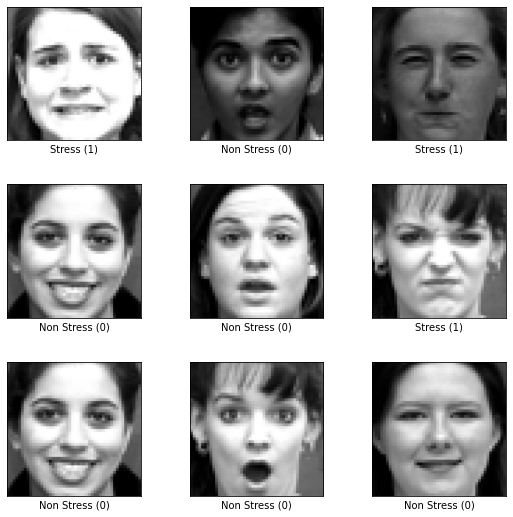

In [ ]:
tfds.show_examples(raw_train, builder.info)

### Format the Data

We can use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [ ]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

Now shuffle and batch the data.

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 20 epochs, you should see ~90%+ accuracy.


In [ ]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 4/20 [=====>........................] - ETA: 3s - loss: 0.8195 - accuracy: 0.4898

20/20 [==============================] - 6s 110ms/step - loss: 0.8195 - accuracy: 0.4898


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.49


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
25/25 [==============================] - 12s 54ms/step - loss: 0.7114 - accuracy: 0.6000 - val_loss: 0.6898 - val_accuracy: 0.6122
Epoch 2/20
25/25 [==============================] - 3s 41ms/step - loss: 0.6770 - accuracy: 0.6127 - val_loss: 0.6604 - val_accuracy: 0.6531
Epoch 3/20
25/25 [==============================] - 4s 51ms/step - loss: 0.6545 - accuracy: 0.6178 - val_loss: 0.6330 - val_accuracy: 0.6633
Epoch 4/20
25/25 [==============================] - 3s 56ms/step - loss: 0.6358 - accuracy: 0.6204 - val_loss: 0.6130 - val_accuracy: 0.6735
Epoch 5/20
25/25 [==============================] - 3s 41ms/step - loss: 0.6188 - accuracy: 0.6229 - val_loss: 0.5956 - val_accuracy: 0.6837
Epoch 6/20
25/25 [==============================] - 3s 42ms/step - loss: 0.6039 - accuracy: 0.6369 - val_loss: 0.5769 - val_accuracy: 0.6837
Epoch 7/20
25/25 [==============================] - 4s 43ms/step - loss: 0.5905 - accuracy: 0.6420 - val_loss: 0.5618 - val_accuracy: 0.6837
Epoch 8/20
2

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

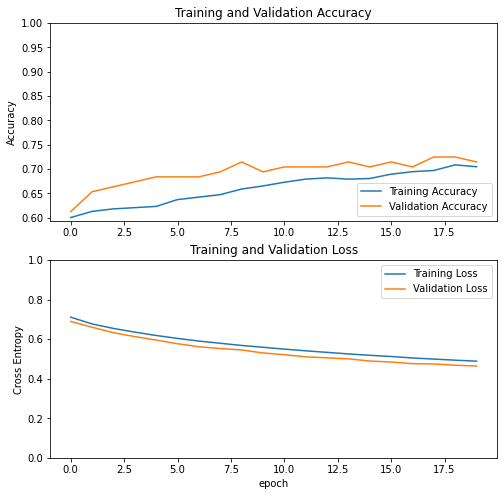

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

Compile the model using a much lower learning rate.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/30
25/25 [==============================] - 15s 90ms/step - loss: 0.5424 - accuracy: 0.7236 - val_loss: 0.4799 - val_accuracy: 0.6837
Epoch 21/30
25/25 [==============================] - 3s 51ms/step - loss: 0.3944 - accuracy: 0.8293 - val_loss: 0.5417 - val_accuracy: 0.6633
Epoch 22/30
25/25 [==============================] - 3s 51ms/step - loss: 0.3096 - accuracy: 0.8930 - val_loss: 0.6209 - val_accuracy: 0.6531
Epoch 23/30
25/25 [==============================] - 4s 52ms/step - loss: 0.2535 - accuracy: 0.9299 - val_loss: 0.7030 - val_accuracy: 0.6531
Epoch 24/30
25/25 [==============================] - 3s 52ms/step - loss: 0.1956 - accuracy: 0.9592 - val_loss: 0.7645 - val_accuracy: 0.6531
Epoch 25/30
25/25 [==============================] - 3s 51ms/step - loss: 0.1455 - accuracy: 0.9847 - val_loss: 0.8613 - val_accuracy: 0.6531
Epoch 26/30
25/25 [==============================] - 4s 69ms/step - loss: 0.1246 - accuracy: 0.9847 - val_loss: 0.9071 - val_accuracy: 0.6531
Epoch

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# mengambil nilai kelas sebenarnya dan prediksi model dari data uji
y_true = np.concatenate([y for x, y in validation_batches], axis=0)
y_pred = np.argmax(model.predict(validation_batches), axis=-1)

# menghitung konfusion matriks
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# menampilkan konfusion matriks
print("Konfusion Matriks:")
print(confusion_matrix(y_true, y_pred))

# menampilkan nilai True Positive, False Positive, True Negative, dan False Negative
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

4/4 [==============================] - 3s 99ms/step
Konfusion Matriks:
[[63  0]
 [35  0]]
True Positive (TP): 0
False Positive (FP): 0
True Negative (TN): 63
False Negative (FN): 35


4/4 [==============================] - 1s 114ms/step


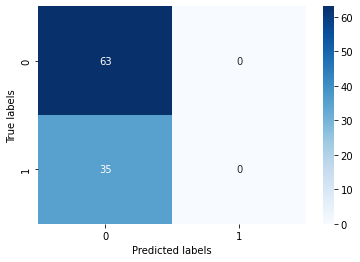

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# mengambil nilai kelas sebenarnya dan prediksi model dari data uji
y_true = np.concatenate([y for x, y in validation_batches], axis=0)
y_pred = np.argmax(model.predict(validation_batches), axis=-1)

# menghitung konfusion matriks
cm = confusion_matrix(y_true, y_pred)

# membuat heatmap konfusion matriks
sns.heatmap(cm, annot=True, cmap='Blues')

# menambahkan label pada sumbu x dan y
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# menampilkan plot
plt.show()


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 99% accuracy.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

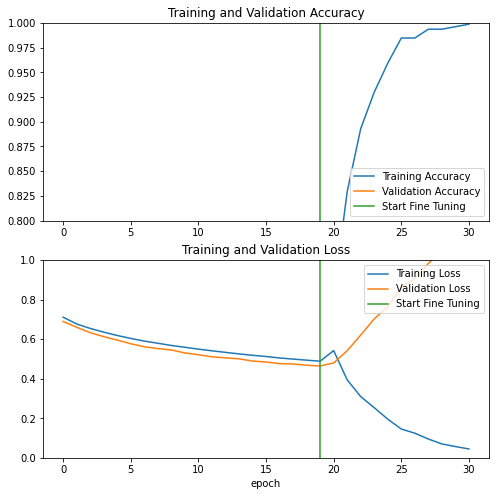

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Infer on a Sample Image

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Stress')

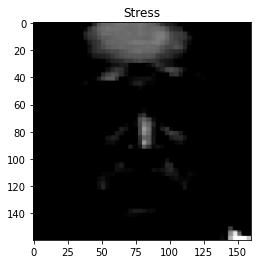

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
     pass
plt.imshow(np.squeeze(image))
plt.title("Non Stress" if model.predict(image) > 0 else "Stress")